<a href="https://colab.research.google.com/github/GabrielGM153/Neural-Network-for-facial-recognition/blob/main/Redes_neuronales_para_reconocimiento_facial%20(eduactional%20project).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Inicialización

## Cargar datos

El conjunto de datos se almacena en la carpeta `/datasets/faces/`
- La carpeta `final_files` con 7600 fotos
- El archivo `labels.csv` con leyendas, con dos columnas: `file_name` y `real_age`

Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.

El archivo de etiqueta se puede cargar como un archivo CSV habitual.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Vamos cargando el archivo que corresponde a las etiquetas:
labels = pd.read_csv('/datasets/faces/labels.csv')

#Imprimimos la info en cuestión:
print(labels.info())
print(labels.head())

FileNotFoundError: [Errno 2] No such file or directory: '/datasets/faces/labels.csv'

## EDA

#### Análisis gráfico de distribución de edades:

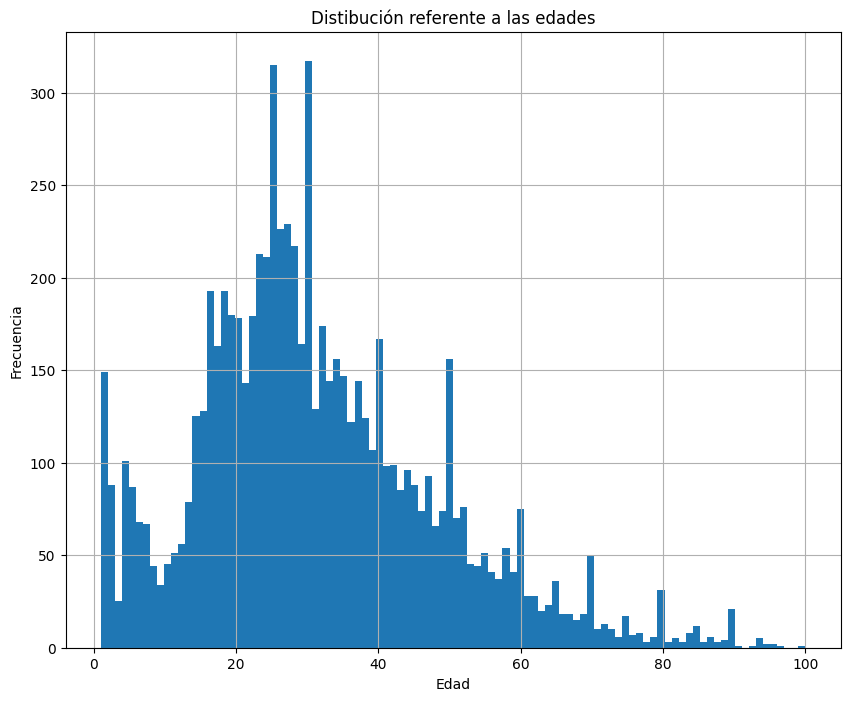

In [ ]:
plt.figure(figsize= (10,8))
labels['real_age'].hist(bins=100)
plt.title('Distibución referente a las edades')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()

Dado el análisis de distribución que presento, se observa una clara inclinación a la izquierda, es decir que, juzgando por los datos, el intervalo en donde se presenta una mayor concentración de edad es de los 15 a los 40 años aproximadamente.

**Se ofrece una muestra de las imágenes, para comprobar que las mismas se encuentran entre el mismo intervalo correspondiente a la edad que comento:**

Found 7591 validated image filenames.


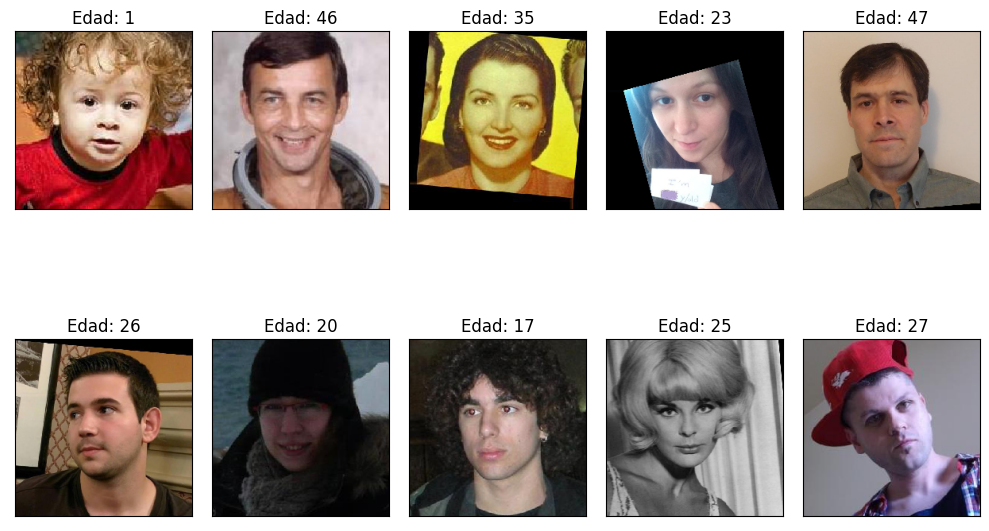

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
sample_gen = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=10,
    class_mode='raw',
    seed=42
)

features, target = next(sample_gen)

fig = plt.figure(figsize=(10, 10))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.title(f'Edad: {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


#### Conclusiones

Al tener un sesgo en los datos, es decir, que esta distribución es muy específica en relación al rango de edad en cuestión, el conjunto de datos está desequilibrado, por lo que puede afectar al aprendizaje del modelo, ya que personas de corta edad o de edad avanzada tienen una presencia poco significativa.

Y esto, primeramente, es una alerta para el uso del modelo, pero al mismo tiempo, nos da una luz verde, en términos de sus aplicaciones, por ejemplo: una apicación orientada a edad laboral, ya que como esboza el gráfico, la concentración estpa entre los 15 y los 40 años, pero se puede acotar de los 18 a los 40.

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crear un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [ ]:
def load_train(path):
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range=20,
        zoom_range=0.2
    )

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=42
    )

    return train_gen_flow

In [ ]:
def load_test(path):
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta.
    """
    labels = pd.read_csv(path + 'labels.csv')

    test_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    )

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42
    )

    return test_gen_flow

In [ ]:
def create_model(input_shape):
    """
    Define el modelo.
    """
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='mean_absolute_error',
        metrics=['mae']
    )

    return model

In [ ]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):
    """
    Entrena el modelo dados los parámetros.
    """
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )

    return model

### Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [ ]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:

    f.write(init_str)
    f.write('\n\n')

    for fn_name in [load_train, load_test, create_model, train_model]:

        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Resultado

Coloca aquí el resultado de la plataforma GPU como una celda Markdown.

## Conclusiones

# Lista de revisión

- [ ]  El Notebook estaba abierto
- [ ]  El código no tiene errores
- [ ]  Las celdas con el código han sido colocadas en el orden de ejecución
- [ ]  Se realizó el análisis exploratorio de datos
- [ ]  Los resultados del análisis exploratorio de datos se presentan en el notebook final
- [ ]  El valor EAM del modelo no es superior a 8
- [ ]  El código de entrenamiento del modelo se copió en el notebook final
- [ ]  El resultado de entrenamiento del modelo se copió en el notebook final
- [ ]  Los hallazgos se proporcionaron con base en los resultados del entrenamiento del modelo